<h1>
<center>CFRM 421/521</center>
</h1>

<h1>
<center>Terence Chiu</center>
</h1>

<h1>
<center>Homework 1</center>
</h1>

* **Due: Tuesday, April 15, 2025, 11:59 PM**


* Total marks: 49


* Late submissions are allowed, but a 20% penalty per day applies. Your last submission is considered for calculating the penalty.


*  Use this Jupyter notebook as a template for your solutions. **Your solution must be submitted as both one Jupyter notebook and one PDF file on Gradescope.** There will be two modules on Gradescope, one for each file type. The notebook must be already run, that is, make sure that you have run all the code, save the notebook, and then when you reopen the notebook, checked that all output appears as expected. You are allowed to use code from the textbook, textbook website, or lecture notes.

# 1. Preprocessing housing data [10 marks]

Hint: Reading Chapter 2 of the textbook and the accompanying [Jupyter notebook](https://github.com/ageron/handson-ml3/blob/main/02_end_to_end_machine_learning_project.ipynb) on the textbook website may help with this question.

Consider the California housing data from Chapter 2 of the textbook. The following code fetches the data.

In [3]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit

def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()

Next, we create stratified test and training sets based on different income categories.

In [4]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

split_obj = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split_obj.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

Let us separate the features (`X_raw`) and the response variable (`y`).

In [5]:
X_raw = strat_train_set.drop("median_house_value", axis=1)
y = strat_train_set["median_house_value"].copy()


## (a) Handling missing values [1 mark]

Let us find out if there are any missing values in our features. As the code below indicates, out of 16512 observations, 158 have missing values. Further inspection shows that `total_bedrooms` has missing values (only a few missing values are shown below).

In [6]:
X_raw.shape

(16512, 9)

In [7]:
X_raw[X_raw.isnull().any(axis=1)].shape

(168, 9)

In [8]:
X_raw[X_raw.isnull().any(axis=1)].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
14452,-120.67,40.50,15.0,5343.0,NaN,2503.0,902.0,3.5962,INLAND
18217,-117.96,34.03,35.0,2093.0,NaN,1755.0,403.0,3.4115,<1H OCEAN
11889,-118.05,34.04,33.0,1348.0,NaN,1098.0,257.0,4.2917,<1H OCEAN
20325,-118.88,34.17,15.0,4260.0,NaN,1701.0,669.0,5.1033,<1H OCEAN
14360,-117.87,33.62,8.0,1266.0,NaN,375.0,183.0,9.8020,<1H OCEAN


**Task:** Read the subsection "Data Cleaning" in Chapter 2 of the textbook. Use the `sklearn.impute.SimpleImputer` class to fill the missing values in the numerical features (everything except `ocean_proximity`) with the median of the corresponding feature.

**Solution:**

In [9]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

housing_num = X_raw.select_dtypes(include=[np.number])
imputer.fit(housing_num)

X = imputer.transform(housing_num)

housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)

housing_tr

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292
...,...,...,...,...,...,...,...,...
14207,-118.40,33.86,41.0,2237.0,597.0,938.0,523.0,4.7105
13105,-119.31,36.32,23.0,2945.0,592.0,1419.0,532.0,2.5733
19301,-117.06,32.59,13.0,3920.0,775.0,2814.0,760.0,4.0616
19121,-118.40,34.06,37.0,3781.0,873.0,1725.0,838.0,4.1455


## (b) Handling categorical features  [2 marks]
ML algorithms generally work with numerical values. So, we need to convert categorical features to numerical values. One way is to simply map each category to an integer. Another alternative is to use **one-hot encoding**.

**Task:** Read subsection "Handling Text and Categorical Attributes" in Chapter 2 of the textbook. Then use the `sklearn.preprocessing.OrdinalEncoder` class and the `sklearn.preprocessing.OneHotEncoder` class to transform the `ocean_proximity` feature to integers and one-hot vectors. Explain why it is more appropriate to use one-hot encoding.

**Solution:**

In [10]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder


housing_cat = X_raw[["ocean_proximity"]]
housing_cat.head(10)

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

print(housing_cat_1hot)

print(cat_encoder.categories_)

print(housing_cat_1hot.toarray())

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 16512 stored elements and shape (16512, 5)>
  Coords	Values
  (0, 3)	1.0
  (1, 0)	1.0
  (2, 1)	1.0
  (3, 1)	1.0
  (4, 4)	1.0
  (5, 1)	1.0
  (6, 0)	1.0
  (7, 3)	1.0
  (8, 0)	1.0
  (9, 0)	1.0
  (10, 1)	1.0
  (11, 0)	1.0
  (12, 0)	1.0
  (13, 1)	1.0
  (14, 4)	1.0
  (15, 0)	1.0
  (16, 1)	1.0
  (17, 3)	1.0
  (18, 1)	1.0
  (19, 0)	1.0
  (20, 0)	1.0
  (21, 4)	1.0
  (22, 1)	1.0
  (23, 3)	1.0
  (24, 1)	1.0
  :	:
  (16487, 1)	1.0
  (16488, 0)	1.0
  (16489, 0)	1.0
  (16490, 3)	1.0
  (16491, 1)	1.0
  (16492, 4)	1.0
  (16493, 4)	1.0
  (16494, 1)	1.0
  (16495, 0)	1.0
  (16496, 1)	1.0
  (16497, 0)	1.0
  (16498, 0)	1.0
  (16499, 4)	1.0
  (16500, 0)	1.0
  (16501, 0)	1.0
  (16502, 0)	1.0
  (16503, 0)	1.0
  (16504, 0)	1.0
  (16505, 0)	1.0
  (16506, 1)	1.0
  (16507, 0)	1.0
  (16508, 1)	1.0
  (16509, 4)	1.0
  (16510, 0)	1.0
  (16511, 4)	1.0
[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype=object)]
[[0. 0. 0. 1. 0.]


One Hot encoding creates a binary attritbure per category and ensures that only one attribute will equal 1 (hot). The attributes <1H OCEAN, INLAND, ISLAND, NEAR BAY, and NEAR OCEAN do not have a relative order to each other and are rather independent. Ordinal encoding makes the ML algorithm assume that closer values imply a closer relationship which is false, for example <1H OCEAN and NEAR BAY are really similar. One Hot Encoding remembers which categories it was trained on.

## (c) Feature engineering [2 marks]

Often it may be useful to experiment with transforming and combining features to create new features that may be expected to better predict the target variable. Features that are skewed or heavily tailed can be logged to make them closer to normal. An example of a feature combination is instead of using the number of bedrooms, which may not be meaningful by itself, we should consider the number of bedrooms relative to the number of rooms.

**Task:** Read the subsections "Custom Transformers" and "Transformation Pipelines" in Chapter 2 of the textbook. Use the `sklearn.preprocessing.FunctionTransformer` class take the log of `population`, and to create the ratio `total_bedrooms/total_rooms`. Print these two transformed features.

**Solution:**

In [11]:
from sklearn.preprocessing import FunctionTransformer
import numpy as np

log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)
log_pop = log_transformer.transform(housing_tr[["population"]])


ratio_transformer = FunctionTransformer(lambda X: X[:,[0]]/X[:,[1]])
ratio_input = housing_tr[["total_bedrooms","total_rooms"]].values
room_ratio = ratio_transformer.transform(ratio_input)

print(len(room_ratio))


print("Log of population:\n", log_pop[:5])
print("\nRatio of total_bedrooms to total_rooms:\n", room_ratio[:5])

16512
Log of population:
        population
13096    7.362645
14973    6.501290
3785     6.331502
14689    7.520235
20507    7.555905

Ratio of total_bedrooms to total_rooms:
 [[0.33574225]
 [0.18015267]
 [0.20036934]
 [0.20388117]
 [0.27737059]]


## (d) Feature scaling and transformation [1 mark]

Many ML algorithms do not perform well if the features have different scales (some very small, and others very large). In such scenarios, one should transform the features so that they have a similar range of values. There are two common ways to achieve this. In **min-max** scaling, we subtract the feature from its minimum value and then divide by its range (i.e. maximum value minus minimum value) so that the scaled values are between 0 and 1. In **standardization**, we subtract the values from the average and divide by the standard deviation, so that the transformed values has mean 0 and variance 1, here we focus on the latter.

**Task:** Read the subsection "Feature Scaling and Transformation" in Chapter 2 of the textbook. Use the `sklearn.preprocessing.StandardScaler` class to scale the numerical features using standardization.

**Solution:**

In [12]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
housing_num_tr_std_scaled = std_scaler.fit_transform(housing_tr)
housing_num_tr_std_scaled


array([[-1.42303652,  1.0136059 ,  1.86111875, ...,  0.13746004,
         1.39481249, -0.93649149],
       [ 0.59639445, -0.702103  ,  0.90762971, ..., -0.69377062,
        -0.37348471,  1.17194198],
       [-1.2030985 ,  1.27611874,  0.35142777, ..., -0.78876841,
        -0.77572662, -0.75978881],
       ...,
       [ 1.25620853, -1.42870103, -1.23772062, ...,  1.26829911,
         0.67913534,  0.1010487 ],
       [ 0.58639727, -0.73960483,  0.66925745, ...,  0.27356264,
         0.88286825,  0.14539615],
       [-1.41803793,  0.94797769,  1.22545939, ..., -0.67915557,
        -0.75221898, -0.31034135]])

## (e) Transformation pipelines [4 marks]

Usually, we have to perform several steps before the data is ready to be fed to an ML algorithm. Scikit-Learn's `ColumnTransformer` and `Pipeline` classes provides a systematic way of "packaging" such a sequence of transformations.

**Task:** Read the subsection "Transformation Pipelines" in Chapter 2 of the textbook. Then create one pipeline that combines the above steps  in the following way applied to the original "raw" features `X_raw`: part (a) (a median imputer for numerical features), part (c) (create the ratios `total_bedrooms/total_rooms`, `total_rooms/households`, `population/households`; and take the log of `total_bedrooms`, `total_rooms`, `population`, `households`, `median_income`), part (d) (a standard scaler for all numerical features, including the transformed features), part (b) (one-hot encoding for categorical variables). Call your transformed features `X`, and print it.

**Solution:**

In [13]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector


num_attribs = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", "median_income"]
cat_attribs = ["ocean_proximity"]

def column_ratio(X):
    return X[:, [0]] / X[:, [1]]
def ratio_name(function_transformer, feature_names_in):
    return ["ratio"]
def ratio_pipeline():
    return make_pipeline(SimpleImputer(strategy="median"), FunctionTransformer(column_ratio, feature_names_out=ratio_name), StandardScaler())

cat_pipeline = make_pipeline(SimpleImputer(strategy="most_frequent"), OneHotEncoder(handle_unknown="ignore"))

log_pipeline = make_pipeline(SimpleImputer(strategy="median"), FunctionTransformer(np.log, feature_names_out="one-to-one"), StandardScaler())

default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())

preprocessing = ColumnTransformer([
    ("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]), (
    "rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
    ("people_per_house", ratio_pipeline(), ["population", "households"]),
    ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population", "households", "median_income"]),
    ("cat", cat_pipeline, make_column_selector(dtype_include=object)),
    ],
    remainder=default_num_pipeline)


X = preprocessing.fit_transform(X_raw)
print(pd.DataFrame(X))
print("Shape: ", X.shape)
preprocessing.get_feature_names_out()


             0         1         2         3         4         5         6   \
0      1.846624 -0.866027 -0.330204  1.324114  0.637892  0.456906  1.310369   
1     -0.508121  0.024550 -0.253616 -0.252671 -0.063576 -0.711654 -0.142030   
2     -0.202155 -0.041193 -0.051041 -0.925266 -0.859927 -0.941997 -0.913030   
3     -0.149006 -0.034858 -0.141475  0.952773  0.943475  0.670700  0.925373   
4      0.963208 -0.666554 -0.306148  1.437622  1.003590  0.719093  1.481464   
...         ...       ...       ...       ...       ...       ...       ...   
16507  0.804368 -0.452111 -0.269780  0.465581  0.109720 -0.247054  0.379471   
16508 -0.192328  0.036792 -0.073741  0.454022  0.477277  0.314542  0.402773   
16509 -0.242492 -0.109987  0.158542  0.824206  0.859552  1.243381  0.889897   
16510  0.259775 -0.360937 -0.210332  0.987851  0.811293  0.579462  1.023329   
16511  3.612710 -1.323972  0.049584 -1.072179 -2.091543 -0.679447 -0.853784   

             7    8    9    10   11   12        13 

array(['bedrooms__ratio', 'rooms_per_house__ratio',
       'people_per_house__ratio', 'log__total_bedrooms',
       'log__total_rooms', 'log__population', 'log__households',
       'log__median_income', 'cat__ocean_proximity_<1H OCEAN',
       'cat__ocean_proximity_INLAND', 'cat__ocean_proximity_ISLAND',
       'cat__ocean_proximity_NEAR BAY', 'cat__ocean_proximity_NEAR OCEAN',
       'remainder__longitude', 'remainder__latitude',
       'remainder__housing_median_age'], dtype=object)

# 2. Fine-tuning models [16 marks]

Hint: Reading Chapter 2 of the textbook and the accompanying [Jupyter notebook](https://github.com/ageron/handson-ml3/blob/main/02_end_to_end_machine_learning_project.ipynb) on the textbook website may help with this question.

## (a) Linear regression [2 marks]

**Task:** Use the `sklearn.linear_model.LinearRegression` class to fit a linear regression to the training set in Question 1. Use the processed features `X` that you obtained in 1(e) as predictors and `y` (the median house values) as the response. Return fitted values of the response for the first 10 observations of the training set.

**Solution:**

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

lin_reg = LinearRegression()
lin_reg.fit(X, y)
housing_predictions = lin_reg.predict(X)
print("Fitted values for first 10 observations of training set")
print(housing_predictions[:10].round(-2))

Fitted values for first 10 observations of training set
[260100. 357900. 125800. 110000. 298900. 206400. 306800. 326900. 162300.
  68800.]


## (b) RMSE and MAE  [2 marks]

We can measure the performance with root mean square error (RMSE) and mean absolute error (MAE).

**Task:** Use `mean_squared_error` and `mean_absolute_error` functions from `sklearn.metrics` to calculate the in-sample RMSE and MAE of the linear regression that you fit in part (a).

**Solution:**

In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

lin_rmse = np.sqrt(mean_squared_error(y,housing_predictions))
lin_mae = mean_absolute_error(y, housing_predictions)
print("In-sample RMSE: ", lin_rmse)
print("In-sample MAE: ", lin_mae)

In-sample RMSE:  70630.22169174395
In-sample MAE:  53034.28396497742


## (c) Cross validation  [3 marks]

In part (b), we evaluated the in-sample performance of the linear regression model. To obtain out-of-sample performance, we use K-fold cross validation.

**Task:** Use the `cross_val_score` function from `sklearn.model_selection` to perform 10-fold  cross validation on the linear regression from part (a) and return the values of **RMSE**. Return the 10 RMSE scores as well as their mean.

In [16]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import numpy as np

lin_reg_cv = LinearRegression()

neg_mse_scores = cross_val_score(lin_reg_cv, X, y, scoring='neg_mean_squared_error', cv=10)
rmse_scores = np.sqrt(-neg_mse_scores)

print("10-fold RMSE scores:", rmse_scores)
print("Mean RMSE:", rmse_scores.mean())

10-fold RMSE scores: [72183.9055149  69449.07233135 68141.82330925 82348.92814938
 70200.08524327 70974.12115166 70512.16910063 73276.85042458
 69387.52951303 71463.70091766]
Mean RMSE: 71793.81856557202


**Solution:**

## (d) Alternatives to linear regression [3 marks]
Let us consider fitting two alternative models, namely, **decision trees** and **random forests**. These models will be discussed in future lectures. The following code fits a decision tree and obtains the fitted response for the first 10 observations.

In [17]:
from sklearn.tree import DecisionTreeRegressor
dt_reg = DecisionTreeRegressor(random_state=42)
dt_reg.fit(X,y)

DecisionTreeRegressor(random_state=42)

In [18]:
dt_reg.predict(X[:10,])

array([458300., 483800., 101700.,  96100., 361800.,  92600., 349300.,
       440900., 160100., 183900.])

The following code does the same for the random forest model.

In [19]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor(bootstrap=True, n_estimators=100, max_depth=5, random_state=42)
rf_reg.fit(X, y)

RandomForestRegressor(max_depth=5, random_state=42)

In [20]:
rf_reg.predict(X[:10,])

array([226052.57663663, 408572.3162281 , 100944.59292661,  95012.98416211,
       323566.08786234, 135098.37280907, 283371.7148996 , 357336.26089032,
       167697.90412093, 146436.2407077 ])

**Task:** Find the in-sample performance of the decision tree and the random forest using RMSE on the training set. Also, find the out-of-sample performance by 10-fold cross validation as you did in part (c). Which of the 3 models has the best in-sample performance? Which has the best out-of-sample performance?

**Solution:**

In [21]:
dt_predictions = dt_reg.predict(X)
dt_rmse_in = np.sqrt(mean_squared_error(y, dt_predictions))
dt_neg_mse_scores = cross_val_score(dt_reg, X, y, scoring='neg_mean_squared_error', cv=10)
dt_rmse_cv = np.sqrt(-dt_neg_mse_scores)

rf_predictions = rf_reg.predict(X)
rf_rmse_in = np.sqrt(mean_squared_error(y, rf_predictions))
rf_neg_mse_scores = cross_val_score(rf_reg, X, y, scoring='neg_mean_squared_error', cv=10)
rf_rmse_cv = np.sqrt(-rf_neg_mse_scores)

print("Linear Regression In-sample RMSE:", lin_rmse)
print("Decision Tree In-sample RMSE:", dt_rmse_in)
print("Random Forest In-sample RMSE:", rf_rmse_in)
print()

print("Linear Regression CV RMSE:", lin_rmse)  # already computed earlier
print("Decision Tree 10-fold CV RMSE:", dt_rmse_cv)
print("Decision Tree Mean CV RMSE:", dt_rmse_cv.mean())
print("Random Forest 10-fold CV RMSE:", rf_rmse_cv)
print("Random Forest Mean CV RMSE:", rf_rmse_cv.mean())

Linear Regression In-sample RMSE: 70630.22169174395
Decision Tree In-sample RMSE: 0.0
Random Forest In-sample RMSE: 62145.4331743811

Linear Regression CV RMSE: 70630.22169174395
Decision Tree 10-fold CV RMSE: [67898.40100744 67248.54149778 67243.39802711 72035.287263
 68898.44321855 71008.46519973 71362.02678113 74060.25775818
 71016.06635454 69991.86971249]
Decision Tree Mean CV RMSE: 70076.27568199515
Random Forest 10-fold CV RMSE: [64285.5681693  64416.01160789 61285.39123064 62717.91644372
 62975.51019993 64267.50742936 64049.97630137 64749.28015876
 63792.05556927 64654.70321247]
Random Forest Mean CV RMSE: 63719.39203227045


The Decision Tree model has the best in-sample performance (RMSE of 0.0) but suffers from overfitting.

The Random Forest not only fits the training data well (with an in-sample RMSE lower than Linear Regression) but also shows the best out-of-sample performance, making it the preferable model for generalization.

## (e) Choosing optimal values of hyperparameters using cross validation [4 marks]

Most ML algorithms have **hyperparameters**. These hyperparameters control the learning process and should not be confused with the model parameters (which are the unknown values that are being estimated). For example, the random forest algorithm has hyperparameter including `n_estimators` and `max_features`. To fine-tune a model, we should find good values of the hyperparameters based on out-of-sample performance.

**Task:** Read the subsections "Grid Search" and "Randomized Search" in Chapter 2 of the textbook. Consider the random forest model with the argument `random_state=42`. Use the `sklearn.model_selection.GridSearchCV` class to choose the best hyperparameter values for `max_features` over the values 4, 6, 8, 10 and `n_estimators` over the values 10, 50, 100. Use 3-fold cross-validation with RMSE when searching for the best hyperparameters.

Next, use the `sklearn.model_selection.RandomizedSearchCV` class to perform a randomized search with 10 iterations, where  `max_features` is a uniform random integer between 2 and 20 and `n_estimators` is a uniform random integer between 10 and 200. `RandomizedSearchCV` must include the argument `random_state=42`.


In both functions, you may use the argument `n_jobs=-1` to use all avaliable processor cores to speed up the calculation. Based on all of your results, what are the best hyperparameter values?

**Solution:**

In [22]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint

param_grid = {
    'max_features': [4, 6, 8, 10],
    'n_estimators': [10, 50, 100]
}

grid_search = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid,
    cv=3,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(X, y)

print("Best hyperparameters from GridSearchCV:", grid_search.best_params_)



param_distributions = {
    'max_features': randint(low=2, high=20),
    'n_estimators': randint(low=10, high=200)
}

random_search = RandomizedSearchCV(
    RandomForestRegressor(random_state=42),
    param_distributions=param_distributions,
    n_iter=10,
    cv=3,
    scoring='neg_root_mean_squared_error',
    random_state=42,
    n_jobs=-1
)

random_search.fit(X, y)

print("Best hyperparameters from RandomizedSearchCV:", random_search.best_params_)

Best hyperparameters from GridSearchCV: {'max_features': 6, 'n_estimators': 100}
Best hyperparameters from RandomizedSearchCV: {'max_features': 7, 'n_estimators': 139}


Output for above done via Google Colab (My macbook cannot run above code under ten minutes):
<br>Best hyperparameters from GridSearchCV: {'max_features': 6, 'n_estimators': 100}
<br>Best hyperparameters from RandomizedSearchCV: {'max_features': 7, 'n_estimators': 139}

## (f) Evaluating your final model using the test set [2 marks]

The last step of a ML project is to evaluate your (fine-tuned) model using the test set. The goal of this step is to estimate the out-of-sample performance of your trained model on new data. **Be careful not to train your model using the test set.** Do not use `.fit()` or `.fit_tranform()` of your estimators or pipelines. Also, **do not fine tune your hyperparameters after finding out the performance of a model on the test set as that would be data snooping.**

**Task:** Using the test set, find the RMSE of your best model in part (e).

**Solution:**

In [23]:
grid_cv_res = pd.DataFrame(grid_search.cv_results_)
grid_cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
grid_cv_res.head()

rs_cb_res = pd.DataFrame()


In [24]:
X_test = strat_test_set.drop("median_house_value", axis =1)
y_test = strat_test_set["median_house_value"].copy()

final_model = random_search.best_estimator_

X_test_processed = preprocessing.fit_transform(X_test)

final_predictions = final_model.predict(X_test_processed)

final_rmse = np.sqrt(mean_squared_error(y_test, final_predictions))
print("Final RMSE:", final_rmse)

Final RMSE: 58506.261432360894


# 3. Regularizing linear regression [6 marks]

Consider the housing data set from Questions 1 and 2.

## (a) Polynomial regression and regularizing [2 marks]

Fit a model that adds degree 3 polynomial terms to the linear regression in 2(a). Next, regularize the model using ridge regression with parameter $\alpha=1$.

**Solution:**

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline

# Assuming X and y are defined from previous parts of the code

poly_pipeline = make_pipeline(PolynomialFeatures(degree=3, include_bias=False), LinearRegression())
poly_pipeline.fit(X, y)

y_pred_poly = poly_pipeline.predict(X)

poly_ridge_pipeline = make_pipeline(PolynomialFeatures(degree=3, include_bias=False), Ridge(alpha=1, solver="sag", random_state=42))
poly_ridge_pipeline.fit(X, y)

y_pred_ridge_poly = poly_ridge_pipeline.predict(X)

## (b) Learning curves [4 marks]

Obtain learning curves using the function `sklearn.model_selection.learning_curve` to plot the learning curve with 5-fold CV for the linear regression model that you fitted in 2(a), the polynomial regression model in 3(a), and the ridge regression model in 3(a). Hence, comment on whether the curves indicate the models are underfitting, overfitting or neither.

**Solution:**

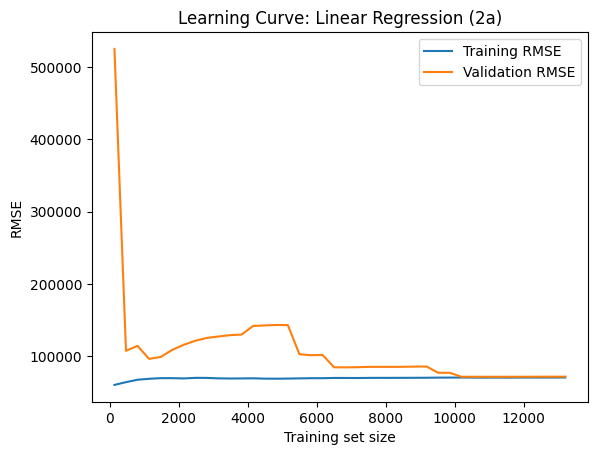

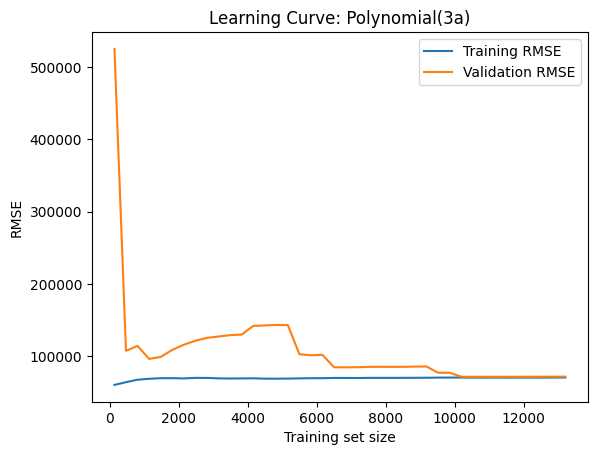

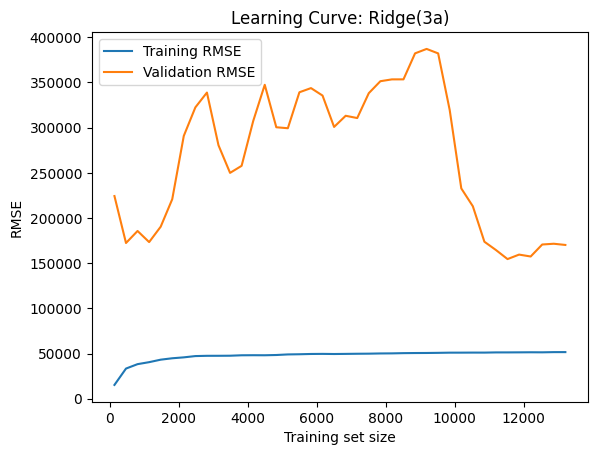

In [32]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
from sklearn.metrics import make_scorer
def rmse_score(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


def plot_learning_curve(estimator, X, y, title=""):
    train_sizes, train_scores, val_scores = learning_curve(
        estimator,
        X,
        y,
        train_sizes=np.linspace(0.01, 1.0, 40),
        scoring="neg_root_mean_squared_error",
        cv=5,
        n_jobs=-1
    )
    train_rmse = -train_scores.mean(axis=1)
    val_rmse = -val_scores.mean(axis=1)

    plt.figure()
    plt.plot(train_sizes, train_rmse, label="Training RMSE")
    plt.plot(train_sizes, val_rmse, label="Validation RMSE")
    plt.title(title)
    plt.xlabel("Training set size")
    plt.ylabel("RMSE")
    plt.legend()
    plt.show()


poly_features=PolynomialFeatures(degree=3, include_bias=False)
X_poly=poly_features.fit_transform(X)
std_scaler=StandardScaler()
X_poly_Ridge = std_scaler.fit_transform(X_poly)
plot_learning_curve(lin_reg, X, y, title="Learning Curve: Linear Regression (2a)")
plot_learning_curve(poly_reg, X, y, title="Learning Curve: Polynomial(3a)")
model_ridge = Ridge(alpha=1)
model_ridge.fit(X_poly_Ridge, y)
plot_learning_curve(model_ridge, X_poly_Ridge, y, title="Learning Curve: Ridge(3a)")

# 4. Default dataset [17 marks]


In this question you will work with the Default dataset, which is a simulated dataset of credit card default for 10000 customers. Download the data as a csv file from [Canvas](https://canvas.uw.edu/files/104571273/download?download_frd=1). The data was originally obtained from the R library ISLR2, and you can read the documentation for the dataset [here](https://cran.rstudio.com/web/packages/ISLR2/ISLR2.pdf).

You want to predict credit card defaults. The target for this classification problem is `default` and all other variables are the features.

## (a) [2 marks]
Load the dataset. If it is stored in a file named `Default.csv` in your working directory, this can be done with the code below. Then use `sklearn.model_selection.train_test_split` to split the data into a training and a test set, using 20% of the data for the test set. When doing the splitting, use the random seed 42.

In [27]:
import os
data = pd.read_csv("Default.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'Default.csv'

**Solution:**

## (b) [3 marks]

Design a pipeline for preprocessing that applies one hot encoding to the categorical features and a standard scaler to the numerical features.

**Solution:**

## (c) [4 marks]
Train a logistic regression classifier and a `SGDClassifier`, and then using 10-fold cross-validation plot the ROC curve of the classifiers and compute their ROC AUC. Use the default arguments, except you must include the argument `random_state=42`.  Furthermore, for the logistic regression, compute the ROC AUC for `C` taking the values 0.001, 0.01, 0.1, 1, 10, 100, to show that the default value of 1 is approximately optimal.

**Solution:**

## (d) [5 marks]

For the classifiers in part (c), plot on the same axes the precision as a function of the threshold and the recall as a function of the threshold. Now suppose you want to achieve a recall of 75%. Consider 4 models:
 1.  The logistic regression classifier in (c),
 2. `SGDClassifier` in (c),
 3. A logistic regression with the argument `class_weight="balanced"`,
 4. `SGDClassifier` with the argument `class_weight="balanced"`.

For each of the 4 models, determine the threshold to achieve a 75% recall based on 10-fold cross-validation. Then determine the corresponding precisions. Which model has the best precision?

**Solution:**

## (e) [3 marks]

Fit the best classifier in (d) to the whole training data, and use it to predict on the test set. What is its accuracy, precision, recall, ROC curve and ROC AUC over the test set?

**Solution:**